In [1]:
#Casual Impact Analysis
#pip install pycausalimpact in Python terminal should be executed first
#Which customers signed up for the delivery club or not - calculated uplift for those who did


In [2]:
#Import required packages
from causalimpact import CausalImpact
import pandas as pd
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#Import data table 

transactions = pd.read_excel("grocery_database.xlsx", sheet_name = "transactions")
campaign_data = pd.read_excel("grocery_database.xlsx", sheet_name = "campaign_data")

In [4]:
transactions #Need to aggregate to unique customer date level

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13
...,...,...,...,...,...,...
38501,870,2020-09-23,437316479610,5,4,51.61
38502,870,2020-09-23,437316479610,2,15,33.77
38503,870,2020-09-30,437385547544,5,3,23.46
38504,870,2020-09-30,437385547544,1,1,18.52


In [5]:
campaign_data
#We have customer id here, so this is at the customer_id level

,customer_id,campaign_name,campaign_date,mailer_type,signup_flag
0,74,delivery_club,2020-07-01,Mailer1,1
1,524,delivery_club,2020-07-01,Mailer1,1
2,607,delivery_club,2020-07-01,Mailer2,1
3,343,delivery_club,2020-07-01,Mailer1,0
4,322,delivery_club,2020-07-01,Mailer2,1
...,...,...,...,...,...
865,372,delivery_club,2020-07-01,Mailer2,1
866,104,delivery_club,2020-07-01,Mailer1,1
867,393,delivery_club,2020-07-01,Mailer2,1
868,373,delivery_club,2020-07-01,Control,0


In [7]:
#Aggregate transactions data to customer

customer_daily_sales = transactions.groupby(["customer_id", "transaction_date"])["sales_cost"].sum().reset_index()

In [9]:
#Merge on the signup flag

customer_daily_sales = pd.merge(customer_daily_sales, campaign_data, how = "inner", on = "customer_id")

In [10]:
customer_daily_sales

,customer_id,transaction_date,sales_cost,campaign_name,campaign_date,mailer_type,signup_flag
0,1,2020-04-10,26.87,delivery_club,2020-07-01,Mailer2,1
1,1,2020-06-02,65.49,delivery_club,2020-07-01,Mailer2,1
2,1,2020-06-10,71.71,delivery_club,2020-07-01,Mailer2,1
3,1,2020-06-19,61.91,delivery_club,2020-07-01,Mailer2,1
4,1,2020-07-02,471.71,delivery_club,2020-07-01,Mailer2,1
...,...,...,...,...,...,...,...
16974,870,2020-08-23,24.10,delivery_club,2020-07-01,Mailer1,0
16975,870,2020-08-28,84.56,delivery_club,2020-07-01,Mailer1,0
16976,870,2020-09-21,186.87,delivery_club,2020-07-01,Mailer1,0
16977,870,2020-09-23,145.49,delivery_club,2020-07-01,Mailer1,0


In [11]:
#We need a table that is just at sales/time, and mean sales per customer for each of signed up and not signed up in two columns

In [12]:
#Pivot the data to aggregate daily sales by signup group
causal_impact_df = customer_daily_sales.pivot_table(index = "transaction_date", #rows of output data frame
                                                   columns = "signup_flag", #one column for those who signed up and one for those who did not
                                                   values = "sales_cost", #Values that will be in the cells of the pivot table
                                                   aggfunc = "mean") #We want means for average daily sales

In [13]:
causal_impact_df #0 = did not sign up, 1 = did sign up

signup_flag,0,1
transaction_date,,
2020-04-01,74.463333,194.488065
2020-04-02,75.558254,185.161667
2020-04-03,74.387353,118.121333
2020-04-04,63.003797,198.525357
2020-04-05,72.440441,145.456000
...,...,...
2020-09-26,67.471786,189.737419
2020-09-27,91.421525,237.735357
2020-09-28,65.681692,157.158750


In [15]:
#Provide a frequency for our DateTimeIndex (avoids a warning message)
causal_impact_df.index.freq = "D" #D for daily

In [18]:
#For causal impact we need the impacted group in the first column
causal_impact_df = causal_impact_df[[1,0]]

In [21]:
#Rename columns to something more meaningful
causal_impact_df.columns = ["member", "non_member"]

In [22]:
causal_impact_df

,member,non_member
transaction_date,,
2020-04-01,194.488065,74.463333
2020-04-02,185.161667,75.558254
2020-04-03,118.121333,74.387353
2020-04-04,198.525357,63.003797
2020-04-05,145.456000,72.440441
...,...,...
2020-09-26,189.737419,67.471786
2020-09-27,237.735357,91.421525
2020-09-28,157.158750,65.681692


In [23]:
#Apply causal impact 

pre_period = ["2020-04-01", "2020-06-30"] #first, last day of pre period
post_period = ["2020-07-01", "2020-09-30"]

In [24]:
ci = CausalImpact(causal_impact_df, pre_period, post_period)

C:\Users\19144\anaconda4\Lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
C:\Users\19144\anaconda4\Lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
C:\Users\19144\anaconda4\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
C:\Users\19144\anaconda4\Li

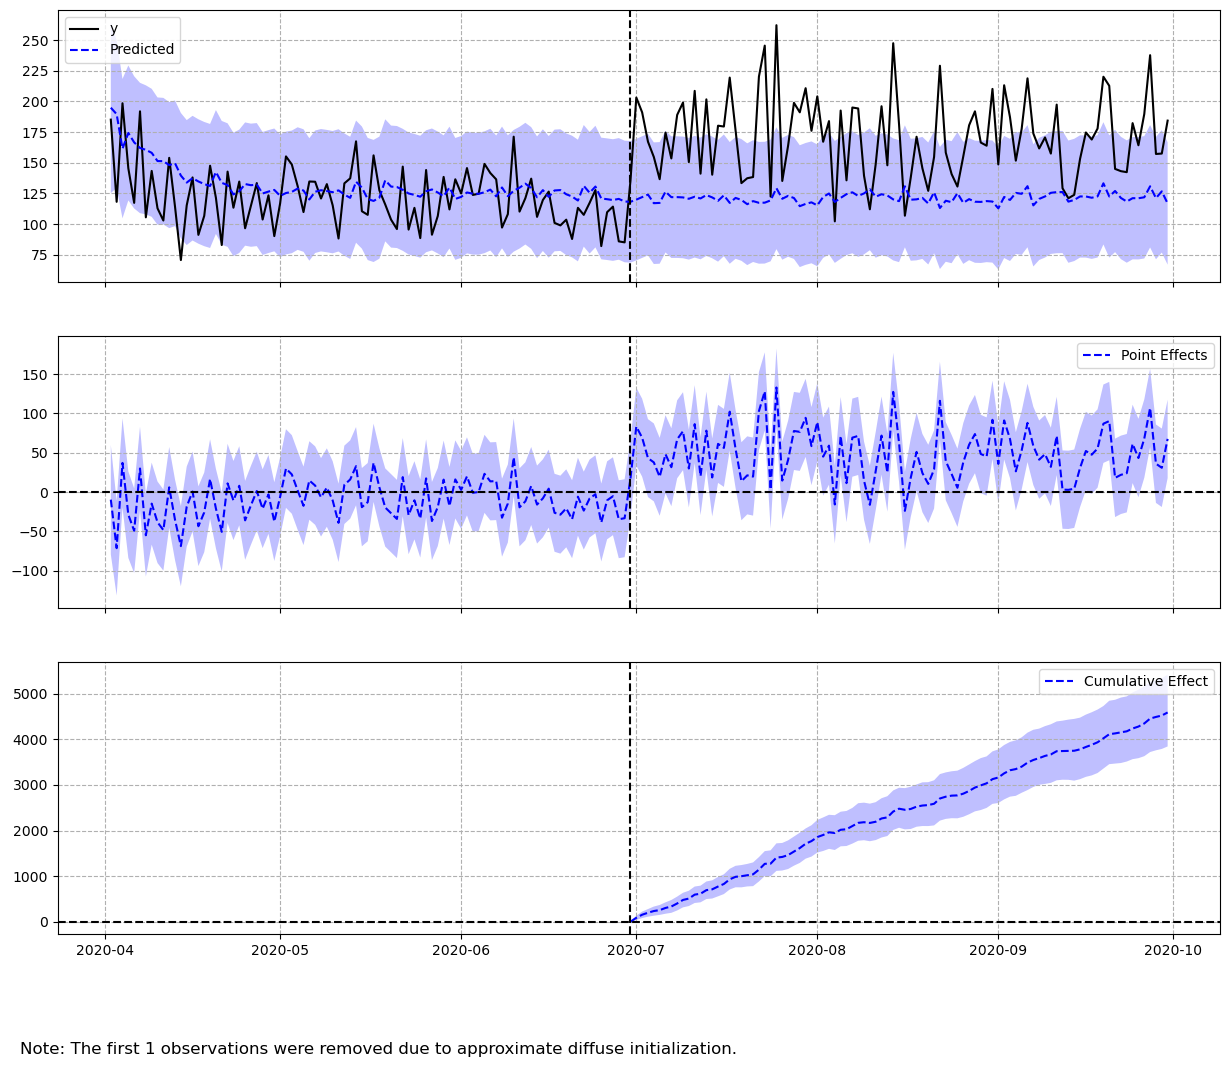

In [26]:
ci.plot()

In [ ]:
#vertical line is the event, 1st of July
#To left is pre period, to right is post period

#y = actual, predicted dotted line is coun